In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sqlalchemy import create_engine
# from matplotlib.patches import Polygon
from pybaseball.plotting import spraychart
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
sqlite_file = '../wisd_data.db'

engine = create_engine(f'sqlite:///{sqlite_file}')

# Read data from SQLite database
pitch_df = pd.read_sql('pitch_data', engine)
hit_df = pd.read_sql('hit_data', engine)
score_df = pd.read_sql('score_data', engine)
events_df = pd.read_sql('events_data', engine)
ball_samples_df = pd.read_sql('ball_samples_data', engine)
bat_samples_df = pd.read_sql('bat_samples_data', engine)


score_df['runs_innings_team1'] = score_df['runs_innings_team1'].apply(ast.literal_eval)
score_df['inning'] = score_df['runs_innings_team1'].apply(lambda x: len(x))

def get_inning(pitch_eventId):
    return score_df[score_df['pitch_eventId'] == pitch_eventId]['inning'].values[0]

events_df['inning'] = events_df['pitch_eventId'].apply(lambda x: get_inning(x))

In [3]:
hitter_dict = {}
for personId, df in events_df.groupby('personId_mlbId'):
    hitter_dict[personId] = list(df['pitch_eventId'].values)

In [4]:
hitter_dict.keys()

dict_keys([172804761, 174158975, 223971350, 290569727, 352830460, 360906992, 412098649, 432216743, 451871192, 459722179, 474808052, 485007791, 505414610, 518481551, 545569723, 558675411, 563942271, 568527038, 590082479, 617522563, 618024297, 654287703, 686425745, 719146721, 719210239, 765710437, 797796542, 797957728, 805688901, 849653732, 854238128])

In [5]:
def plot_at_bat(pitch_eventId, bat_samples_df):
    df = bat_samples_df[bat_samples_df['pitch_eventId'] == pitch_eventId].copy()

    # Fit polynomial curves for each position coordinate
    def fit_polynomial(time, position, degree=3):
        poly = PolynomialFeatures(degree)
        time_poly = poly.fit_transform(time.reshape(-1, 1))
        model = LinearRegression().fit(time_poly, position)
        return model, poly

    # Extract time and position data
    time = df['time'].values
    # head_pos_x = df['head_pos_x'].values
    # head_pos_y = df['head_pos_y'].values
    # head_pos_z = df['head_pos_z'].values

    # handle_pos_x = df['handle_pos_x'].values
    # handle_pos_y = df['handle_pos_y'].values
    # handle_pos_z = df['handle_pos_z'].values

    models_head = {}
    models_handle = {}

    for coord in ['x', 'y', 'z']:
        models_head[coord], _ = fit_polynomial(time, df[f'head_pos_{coord}'].values)
        models_handle[coord], _ = fit_polynomial(time, df[f'handle_pos_{coord}'].values)

    # Predict values for visualization
    time_new = np.linspace(time.min(), time.max(), 100)
    time_new_poly = PolynomialFeatures(degree=3).fit_transform(time_new.reshape(-1, 1))

    head_pos_x_pred = models_head['x'].predict(time_new_poly)
    head_pos_y_pred = models_head['y'].predict(time_new_poly)
    head_pos_z_pred = models_head['z'].predict(time_new_poly)

    handle_pos_x_pred = models_handle['x'].predict(time_new_poly)
    handle_pos_y_pred = models_handle['y'].predict(time_new_poly)
    handle_pos_z_pred = models_handle['z'].predict(time_new_poly)

    # Plotting
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')

    # Plot head trajectory
    ax.plot(head_pos_x_pred, head_pos_y_pred, head_pos_z_pred, label='Head Trajectory', color='b')

    # Plot handle trajectory
    ax.plot(handle_pos_x_pred, handle_pos_y_pred, handle_pos_z_pred, label='Handle Trajectory', color='r')

    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Z Position')
    ax.set_title(pitch_eventId)
    ax.legend()

    plt.show()

In [61]:

bat_samples_df[bat_samples_df['pitch_eventId']=='043ae129-28d4-46b3-a1bc-c98b859cc776']

,pitch_eventId,hit_eventId,event,time,head_pos_x,head_pos_y,head_pos_z,handle_pos_x,handle_pos_y,handle_pos_z
30694,043ae129-28d4-46b3-a1bc-c98b859cc776,d2093734-cd5a-4c58-9705-91186c0e61a7,Hit,-2.560901,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
30695,043ae129-28d4-46b3-a1bc-c98b859cc776,d2093734-cd5a-4c58-9705-91186c0e61a7,First,-0.398996,-3.905020,-0.609139,5.483259,-3.905020,-0.609139,5.483259
30696,043ae129-28d4-46b3-a1bc-c98b859cc776,d2093734-cd5a-4c58-9705-91186c0e61a7,None,-0.395664,-3.902184,-0.608970,5.481382,-3.902184,-0.608970,5.481382
30697,043ae129-28d4-46b3-a1bc-c98b859cc776,d2093734-cd5a-4c58-9705-91186c0e61a7,None,-0.392331,-3.898783,-0.608538,5.480574,-3.898783,-0.608538,5.480574
30698,043ae129-28d4-46b3-a1bc-c98b859cc776,d2093734-cd5a-4c58-9705-91186c0e61a7,None,-0.388997,-3.894856,-0.607812,5.480813,-3.894856,-0.607812,5.480813
...,...,...,...,...,...,...,...,...,...,...
31054,043ae129-28d4-46b3-a1bc-c98b859cc776,d2093734-cd5a-4c58-9705-91186c0e61a7,None,0.797577,-2.750674,-1.019454,5.186642,-2.750674,-1.019454,5.186642
31055,043ae129-28d4-46b3-a1bc-c98b859cc776,d2093734-cd5a-4c58-9705-91186c0e61a7,None,0.800910,-2.754508,-1.022927,5.194197,-2.754508,-1.022927,5.194197
31056,043ae129-28d4-46b3-a1bc-c98b859cc776,d2093734-cd5a-4c58-9705-91186c0e61a7,None,0.804242,-2.758651,-1.025855,5.201377,-2.758651,-1.025855,5.201377
31057,043ae129-28d4-46b3-a1bc-c98b859cc776,d2093734-cd5a-4c58-9705-91186c0e61a7,None,0.807576,-2.763095,-1.028297,5.208204,-2.763095,-1.028297,5.208204


In [7]:
playerId = 223971350
for pitch_eventId, df in bat_samples_df[bat_samples_df['pitch_eventId'].isin(hitter_dict[playerId])].groupby('pitch_eventId'):
    print(pitch_eventId)
    # plot_at_bat(pitch_eventId, df)

043ae129-28d4-46b3-a1bc-c98b859cc776
04cf7eb8-271f-4ac1-894d-f4259dfb4ada
251b7aaa-baaa-4ca6-83e9-72f0dac19140
42ac4615-8b26-4e55-97b8-c6d4a3f9e89b
4fe48dda-9b39-432e-b4fe-b1126822613c
c144ba94-df74-4813-a9b8-7e6a87c8bc33


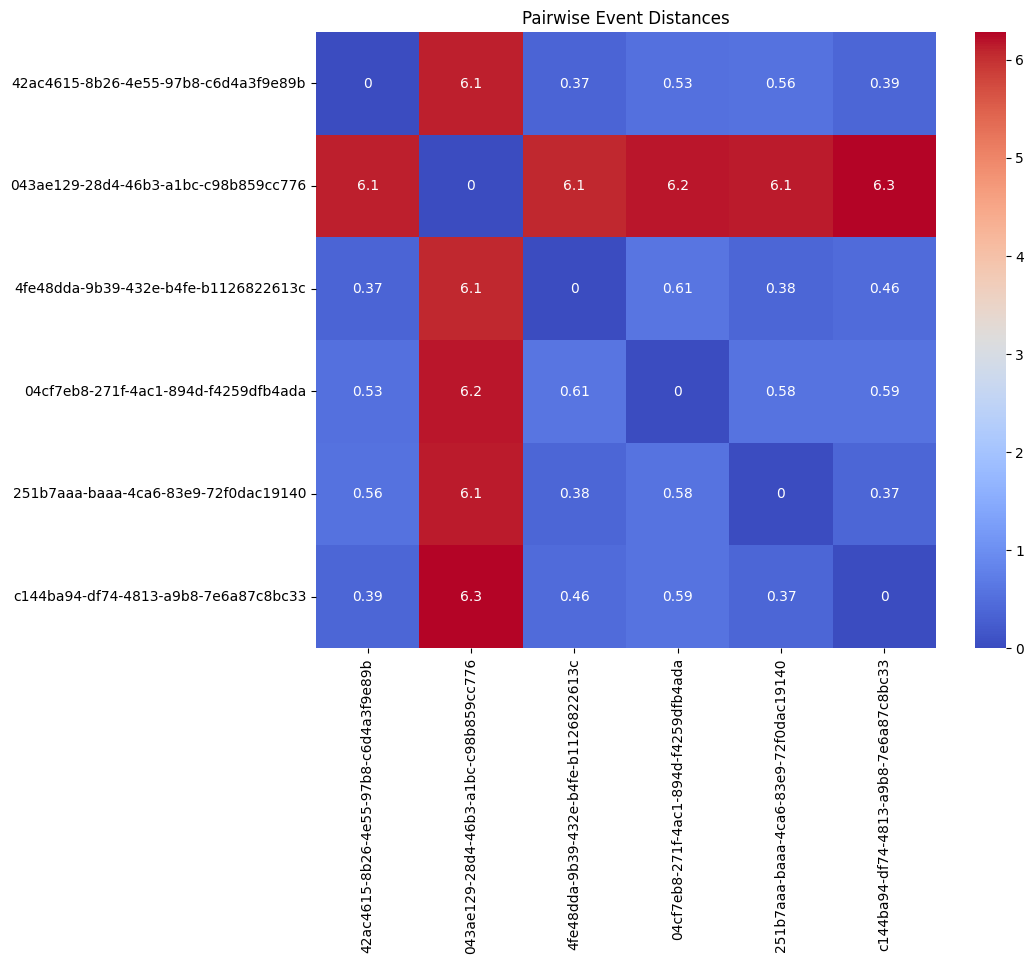

In [11]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import matplotlib.pyplot as plt
import seaborn as sns


# Function to extract features
def extract_features(df, part='head'):
    features = {}
    events = df['pitch_eventId'].unique()
    for event in events:
        subset = df[df['pitch_eventId'] == event]
        features[event] = {
            'mean_x': subset[f'{part}_pos_x'].mean(),
            'mean_y': subset[f'{part}_pos_y'].mean(),
            'mean_z': subset[f'{part}_pos_z'].mean(),
            'var_x': subset[f'{part}_pos_x'].var(),
            'var_y': subset[f'{part}_pos_y'].var(),
            'var_z': subset[f'{part}_pos_z'].var(),
            'length': np.sqrt((np.diff(subset[f'{part}_pos_x'])**2 + np.diff(subset[f'{part}_pos_y'])**2 + np.diff(subset[f'{part}_pos_z'])**2).sum())
        }
    return pd.DataFrame(features).T

# Extract features
df = bat_samples_df[bat_samples_df['pitch_eventId'].isin(hitter_dict[playerId])]
features_df = extract_features(df, part='handle')

# Function to compute pairwise distances
def compute_pairwise_distances(df, method='euclidean'):
    events = df.index
    n = len(events)
    distances = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i+1, n):
            if method == 'euclidean':
                distances[i, j] = euclidean(df.iloc[i].values, df.iloc[j].values)
                distances[j, i] = distances[i, j]
            elif method == 'dtw':
                x1 = df.iloc[i].values
                x2 = df.iloc[j].values
                distances[i, j], _ = fastdtw(x1, x2, dist=euclidean)
                distances[j, i] = distances[i, j]
    
    return pd.DataFrame(distances, index=events, columns=events)

# Compute pairwise distances
distance_matrix = compute_pairwise_distances(features_df, method='euclidean')

# Plot the distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=True, cmap='coolwarm')
plt.title('Pairwise Event Distances')
plt.show()


043ae129-28d4-46b3-a1bc-c98b859cc776


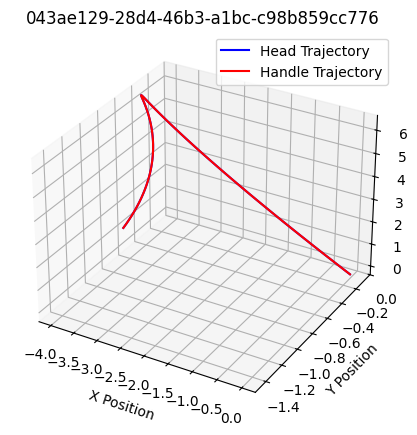

04cf7eb8-271f-4ac1-894d-f4259dfb4ada


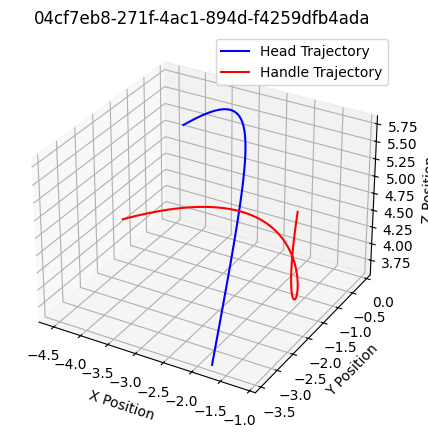

251b7aaa-baaa-4ca6-83e9-72f0dac19140


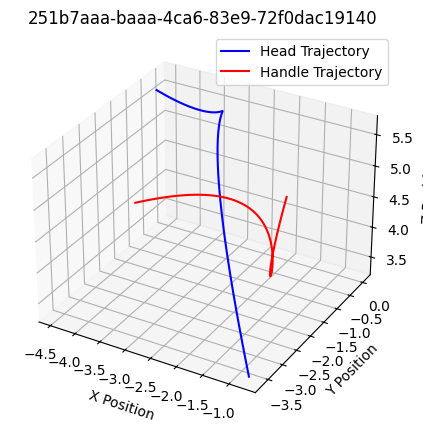

42ac4615-8b26-4e55-97b8-c6d4a3f9e89b


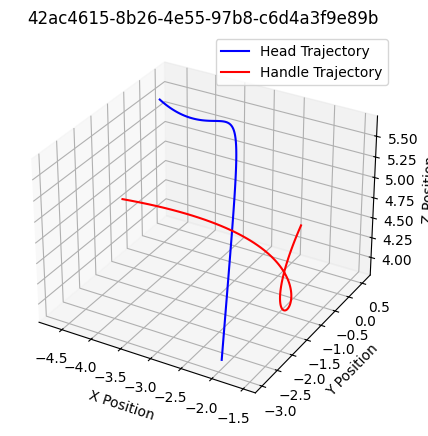

4fe48dda-9b39-432e-b4fe-b1126822613c


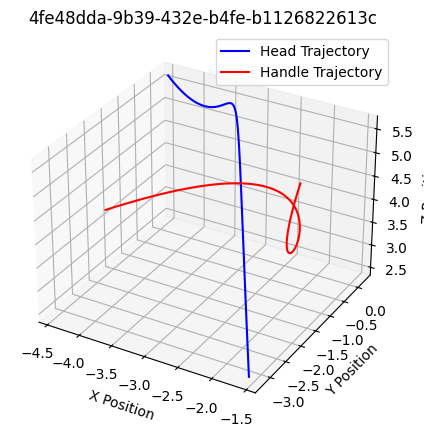

c144ba94-df74-4813-a9b8-7e6a87c8bc33


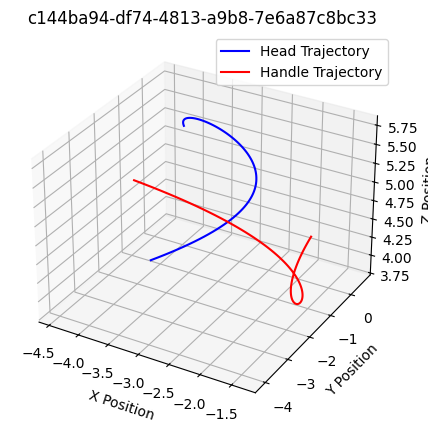

In [60]:
playerId = 223971350
for pitch_eventId, df in bat_samples_df[bat_samples_df['pitch_eventId'].isin(hitter_dict[playerId])].groupby('pitch_eventId'):
    print(pitch_eventId)
    plot_at_bat(pitch_eventId, df)